In [9]:
# 데이터 불러오기

import pandas as pd
import numpy as np
import time
import warnings
import os


warnings.filterwarnings(action='ignore')

parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_data = parent_path + '/data/'
path_stat = parent_path + '/stat/'

print('종목 차트정보 가져오는 중...')
dailychart = pd.read_csv(path_data+'dailychart.csv')
dailychart['date'] = pd.to_datetime(dailychart['date'], format='%Y%m%d')


# 날짜 데이터프레임 생성
df_date = pd.DataFrame(dailychart['date'].unique(), columns=['date'])
min_day = np.min(dailychart['date'])
max_day = np.max(dailychart['date'])
df_date['idx'] = df_date.index

dailychart = pd.merge(dailychart, df_date, on='date')

print("종목정보 가져오는 중...")
stockitems_original = pd.read_csv(path_data+'stockItems.csv', encoding='cp949')   #종목정보 가져오기
stockitems_in_chart = dailychart['code'].unique()
stockitems = stockitems_original.loc[stockitems_original['code'].isin(stockitems_in_chart)]

print("지수정보 가져오는 중...")
dailychart_index = pd.read_csv(path_data+'dailychart_index.csv', encoding='cp949')   #종목정보 가져오기
dailychart_index['date'] = pd.to_datetime(dailychart_index['date'], format='%Y%m%d')
dailychart_index = pd.merge(dailychart_index, df_date, on='date')
dailychart_index = dailychart_index.loc[(min_day <= dailychart_index['date']) & ( dailychart_index['date'] <= max_day)]
dailychart_index = dailychart_index.sort_values(['code','date']).reset_index(drop=True)

# 각 종목별 시작일에 날짜 인덱스를 추가
tmp_df = pd.merge(dailychart.groupby('code', as_index=False)['date'].min(), df_date, on='date' )

# 종목 데이터에 종목별 시작일과 시작날짜 인덱스를 조인
stockitems = pd.merge(stockitems_original, tmp_df, on='code')
stockitems = stockitems.rename(columns = {'date':'firstdate', 'idx':'idx_firstdate'})

pd.options.display.float_format = '{:.0f}'.format

dailychart = dailychart.sort_values(['code','date']).reset_index(drop=True)

print('데이터를 불러왔습니다.')


종목 차트정보 가져오는 중...
종목정보 가져오는 중...
지수정보 가져오는 중...
데이터를 불러왔습니다.


In [31]:

def generate_rolling_mean(df, rolling_mean_period):
    for p in rolling_mean_period:
        column_name = 'rm_' + str(p)
        df[column_name + '_tmp'] = df['close'].rolling(p).mean().shift(-p + 1)
        df_groupby = df.groupby('code')[column_name + '_tmp'].shift(p - 1).rename(column_name)
        df = pd.concat([df, df_groupby], axis=1)
        df = df.drop(columns=column_name + '_tmp')
    return df

# 이평선 1. 골든크로스 (5, 20, 60, 120일선 완전 정배열)
def generate_reg_alignment_fully(df):
    df['reg_alignment'] = False
    df.loc[(df['rm_5'] > df['rm_20']) &  (df['rm_20'] > df['rm_60']) & (df['rm_60'] > df['rm_120']) , 'reg_alignment'] = True
    df['golden_cross'] = False
    df.loc[(df['reg_alignment'] == True) & (df['reg_alignment'].shift(1) == False) & (df['code'] == df['code'].shift(1)), 'golden_cross'] = True
    return df

# 이평선 2. 골든크로스 ([5, 20]일 선이 [60, 120] 위로 놓인 경우)
def generate_reg_alignment_longshort_term(df):
    df['reg_alignment'] = False
    df.loc[(df['rm_5'] > df['rm_60']) &  (df['rm_5'] > df['rm_120']) & (df['rm_20'] > df['rm_60']) & (df['rm_20'] > df['rm_120']), 'reg_alignment'] = True
    df['golden_cross'] = False
    df.loc[(df['reg_alignment'] == True) & (df['reg_alignment'].shift(1) == False) & (df['code'] == df['code'].shift(1)), 'golden_cross'] = True
    return df


"""
# 골든크로스 검증용 데이터 생성
def generate_val_data(df, period):
    idx_golden_cross = df.loc[df['golden_cross']].index
    arr_day = np.arange(0, period + 1)
    
    code = df.loc[idx_golden_cross,'code']
    arr_gc_id = np.repeat(np.arange(0, len(idx_golden_cross)), period+1)
    arr_code = np.repeat(code, period+1)
    arr_day = np.tile(arr_day, len(code))
    
    idx_golden_cross = np.repeat(idx_golden_cross, period+1) + arr_day
    arr = np.stack((idx_golden_cross, arr_gc_id, arr_code, arr_day), axis=-1)
    
    df_val_goldencross = pd.DataFrame(arr, columns = ['index','gc_id','code','days']).set_index('index')

    return df_val_goldencross
"""

# 골든크로스 검증용 데이터 생성 (과거 데이터 생성 기능 포함(period가 음수일 시))
def generate_val_data(df, period):
    idx_golden_cross = df.loc[df['golden_cross']].index
    
    idx_golden_cross = df.loc[df['golden_cross']].index
    if period > 0:
        arr_day = np.arange(0, period+1)
    else:
        arr_day = np.arange(period, 0+1)
    
    code = df.loc[idx_golden_cross,'code']
    arr_gc_id = np.repeat(np.arange(0, len(idx_golden_cross)), np.abs(period)+1)
    arr_code = np.repeat(code, np.abs(period)+1)
    arr_day = np.tile(arr_day, len(code))
    
    idx_golden_cross = np.repeat(idx_golden_cross, np.abs(period)+1) + arr_day
    arr = np.stack((idx_golden_cross, arr_gc_id, arr_code, arr_day), axis=-1)
    
    df_val_goldencross = pd.DataFrame(arr, columns = ['index','gc_id','code','days']).set_index('index')

    return df_val_goldencross


def make_val_data(df, period, condition):
    df_rolling = generate_rolling_mean(df, rolling_mean_period)
    df_rolling = condition(df_rolling)
    df_val_goldencross = generate_val_data(df_rolling, period)

    df_val_goldencross = pd.merge(df_rolling, df_val_goldencross, left_index = True, right_index = True)

    df_val_goldencross = df_val_goldencross.loc[df_val_goldencross['code_x'] == df_val_goldencross['code_y'], 
                                              ['gc_id', 'days', 'code_x', 'section', 'date', 'close', 'rm_5', 'rm_20','rm_60','rm_120', 'reg_alignment']]

    df_val_goldencross = df_val_goldencross.rename(columns={'code_x':'code'})
    df_val_goldencross = df_val_goldencross.sort_values(['gc_id', 'days'])
    
    return df_val_goldencross



In [ ]:
# 골든크로스 검증 데이터 생성

rolling_mean_period = [5,20,60,120]
period = 60

df_val_goldencross = make_val_data(dailychart, period, generate_reg_alignment_longshort_term)
df_val_goldencross.to_csv(path_stat+'val_goldencross_2_longshort_term.csv', index=False)

df_val_goldencross = make_val_data(dailychart_index, period, generate_reg_alignment_longshort_term)
df_val_goldencross.to_csv(path_stat+'val_goldencross_index_2_longshort_term.csv', index=False)


In [38]:
# 골든크로스 훈련 데이터 생성

rolling_mean_period = [5,20,60,120]
period = -60

df_train_goldencross = make_val_data(dailychart, period, generate_reg_alignment_longshort_term)
df_train_goldencross.to_csv(path_stat+'train_goldencross_2_longshort_term.csv', index=False)

df_train_goldencross = make_val_data(dailychart_index, period, generate_reg_alignment_longshort_term)
df_train_goldencross.to_csv(path_stat+'train_goldencross_index_2_longshort_term.csv', index=False)


In [124]:
# 골든크로스 검증 데이터 로딩 및 향후 d일간 수익률 계산

import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

df = pd.read_csv(path_stat+'val_goldencross_2_longshort_term.csv')
df_index = pd.read_csv(path_stat+'val_goldencross_index_2_longshort_term.csv')

df['date'] = pd.to_datetime(df['date'])
df_index['date'] = pd.to_datetime(df_index['date'])
df['close'] = df['close'].astype(float)


def generate_return(df, str_column):
    str_ret_column_day = str_column + '_ret_day'
    str_ret_column_first = str_column + '_ret_first'
    
    df[str_ret_column_day] = (df[str_column]-df[str_column].shift(1)) / df[str_column].shift(1) * 100
    df.loc[df['days'] == 0, str_ret_column_day] = np.nan

    df[str_ret_column_first] = df.groupby('gc_id')[str_column].transform('first')
    df[str_ret_column_first] = (df[str_column] - df[str_ret_column_first]) / df[str_ret_column_first] * 100

    return df

df = generate_return(df, 'close')
df_index = generate_return(df_index, 'close')

df.head(10)

,gc_id,days,code,section,date,close,rm_5,rm_20,rm_60,rm_120,reg_alignment,close_ret_day,close_ret_first
0,0,0,A000020,KOSPI,2014-10-16,"6,260.00","5,908.00","5,600.50","5,341.33","5,567.42",True,nan,0.00
1,0,1,A000020,KOSPI,2014-10-17,"6,280.00","5,986.00","5,640.00","5,354.50","5,569.33",True,0.32,0.32
2,0,2,A000020,KOSPI,2014-10-20,"6,280.00","6,122.00","5,680.00","5,368.50","5,571.50",True,0.00,0.32
3,0,3,A000020,KOSPI,2014-10-21,"6,330.00","6,228.00","5,723.50","5,382.83","5,573.92",True,0.80,1.12
4,0,4,A000020,KOSPI,2014-10-22,"6,360.00","6,302.00","5,768.00","5,398.17","5,576.25",True,0.47,1.60
5,0,5,A000020,KOSPI,2014-10-23,"6,280.00","6,306.00","5,809.50","5,415.83","5,577.92",True,-1.26,0.32
6,0,6,A000020,KOSPI,2014-10-24,"6,200.00","6,290.00","5,848.00","5,432.33","5,579.25",True,-1.27,-0.96
7,0,7,A000020,KOSPI,2014-10-27,"6,500.00","6,334.00","5,898.50","5,454.00","5,583.25",True,4.84,3.83
8,0,8,A000020,KOSPI,2014-10-28,"6,350.00","6,338.00","5,940.50","5,473.00","5,586.08",True,-2.31,1.44
9,0,9,A000020,KOSPI,2014-10-29,"6,220.00","6,310.00","5,979.00","5,492.33","5,588.33",True,-2.05,-0.64


<AxesSubplot:xlabel='days'>

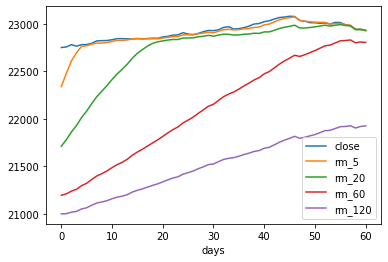

In [6]:
df1 = df.copy()

df1_summary = df1.groupby('days')['close','rm_5', 'rm_20', 'rm_60', 'rm_120'].mean()
df1_summary.plot()

In [125]:
import pandas as pd
from IPython.display import display, HTML

# 골든크로스 발생일로부터 d일 후의 수익률 평균

# 1. 모든 케이스에 대한 평균

df_summary = df.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary[['std_ret_day', 'std_ret_first']] = df.groupby('days')['close_ret_day', 'close_ret_first'].std()


# 2. 코스피, 코스닥 지수에 대한 평균

df_summary_index = df_index.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary_index[['std_ret_day', 'std_ret_first']] = df_index.groupby('days')['close_ret_day', 'close_ret_first'].std()

display(HTML(df_summary.to_html()))
display(HTML(df_summary_index.to_html()))


,close_ret_day,close_ret_first,std_ret_day,std_ret_first
days,,,,
0,nan,0.00,nan,0.00
1,0.16,0.16,3.87,3.87
2,0.11,0.28,3.73,5.68
3,0.08,0.37,3.55,7.03
4,0.07,0.45,3.59,8.20
5,0.07,0.53,3.58,9.25
6,0.09,0.61,3.53,10.07
7,0.07,0.69,3.56,10.94
8,0.10,0.80,3.49,11.94


,close_ret_day,close_ret_first,std_ret_day,std_ret_first
days,,,,
0,nan,0.00,nan,0.00
1,0.11,0.11,0.60,0.60
2,-0.09,0.02,0.90,1.14
3,0.11,0.14,0.96,1.71
4,0.20,0.33,0.85,1.66
5,-0.21,0.11,1.13,2.27
6,-0.24,-0.14,1.48,2.32
7,-0.41,-0.52,1.37,3.31
8,-0.06,-0.71,0.99,3.50


주식 차트 골든크로스 발생 횟수 :  40719


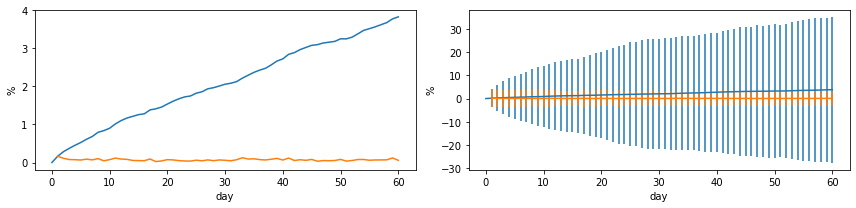

주가 차트 골든크로스 발생 횟수 :  43


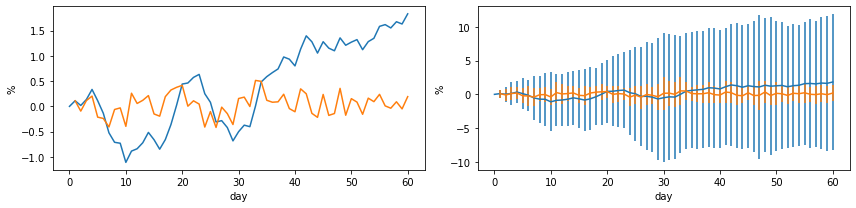

In [133]:
import matplotlib.pyplot as plt


def display_ret(df, str_col_mean_first, str_col_mean_day, str_col_std_first, str_col_std_day):
    plt.subplot(1, 2, 1)
    plt.plot(df[str_col_mean_first])
    plt.plot(df[str_col_mean_day])
    #plt.title('골든크로스 발생일로부터 이후 60일간 평균 수익률')
    plt.xlabel('day')
    plt.ylabel('%')

    plt.subplot(1, 2, 2)
    plt.errorbar(df.index, df[str_col_mean_first], yerr=df[str_col_std_first])
    plt.errorbar(df.index, df[str_col_mean_day], yerr=df[str_col_std_day])
    #plt.title('골든크로스 발생일로부터 이후 60일간 평균 수익률 및 표준편차')
    plt.xlabel('day')
    plt.ylabel('%')

    plt.tight_layout()
    plt.show()

print('주식 차트 골든크로스 발생 횟수 : ', len(df['gc_id'].unique()))
plt.figure(figsize=(12,3))
display_ret(df_summary, 'close_ret_first', 'close_ret_day',  'std_ret_first', 'std_ret_day')

print('주가 차트 골든크로스 발생 횟수 : ', len(df_index['gc_id'].unique()))
plt.figure(figsize=(12,3))
display_ret(df_summary_index, 'close_ret_first', 'close_ret_day',  'std_ret_first', 'std_ret_day')
      

In [135]:
# kospi200, kospi50, kosdaq150 해당 종목에 대한 데이터 추출

pd.options.display.float_format = '{:,.2f}'.format

df_codelist_index = pd.read_excel(path_data+'codelist_KOSPI200.xlsx', dtype={'code':str})
df_codelist_index['code'] = 'A' + df_codelist_index['code'].astype(str)
df_codelist_index['startdate'] = pd.to_datetime(df_codelist_index['startdate'], format='%Y-%m-%d')
df_codelist_index['enddate'] = pd.to_datetime(df_codelist_index['enddate'], format='%Y-%m-%d')

df_codelist_index = df_codelist_index.fillna(pd.to_datetime("today").date())

df_codelist_kospi200 = df_codelist_index.loc[df_codelist_index['index_name']=='KOSPI200']
df_codelist_kospi50 = df_codelist_index.loc[df_codelist_index['index_name']=='KOSPI50']
df_codelist_kosdaq150 = df_codelist_index.loc[df_codelist_index['index_name']=='KOSDAQ150']

df_kospi200 = pd.merge(df, df_codelist_kospi200, on='code')
df_kospi200 = df_kospi200.loc[(df_kospi200['date'] >= df_kospi200['startdate']) & (df_kospi200['date'] <= df_kospi200['enddate'])]

df_kospi50 = pd.merge(df, df_codelist_kospi50, on='code')
df_kospi50 = df_kospi50.loc[(df_kospi50['date'] >= df_kospi50['startdate']) & (df_kospi50['date'] <= df_kospi50['enddate'])]

df_kosdaq150 = pd.merge(df, df_codelist_kosdaq150, on='code')
df_kosdaq150 = df_kosdaq150.loc[(df_kosdaq150['date'] >= df_kosdaq150['startdate']) & (df_kosdaq150['date'] <= df_kosdaq150['enddate'])]

print(len(df_kospi200), len(df_kospi50), len(df_kosdaq150))

195111 49364 122395


In [136]:
# 3. kospi200, kospi50, kosdaq150 해당 종목에 대한 평균

df_summary_kospi200 = df_kospi200.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary_kospi200[['std_ret_day', 'std_ret_first']] = df_kospi200.groupby('days')['close_ret_day', 'close_ret_first'].std()

df_summary_kospi50 = df_kospi50.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary_kospi50[['std_ret_day', 'std_ret_first']] = df_kospi50.groupby('days')['close_ret_day', 'close_ret_first'].std()

df_summary_kosdaq150 = df_kosdaq150.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary_kosdaq150[['std_ret_day', 'std_ret_first']] = df_kosdaq150.groupby('days')['close_ret_day', 'close_ret_first'].std()


display(HTML(df_summary_kospi200.to_html()))
display(HTML(df_summary_kospi50.to_html()))
display(HTML(df_summary_kosdaq150.to_html()))

,close_ret_day,close_ret_first,std_ret_day,std_ret_first
days,,,,
0,nan,0.00,nan,0.00
1,0.11,0.11,2.45,2.45
2,0.01,0.12,2.47,3.58
3,0.04,0.16,2.47,4.49
4,-0.04,0.13,2.42,5.25
5,0.08,0.20,2.53,5.63
6,0.01,0.20,2.47,6.00
7,-0.00,0.19,2.49,6.33
8,0.10,0.28,2.46,6.81


,close_ret_day,close_ret_first,std_ret_day,std_ret_first
days,,,,
0,nan,0.00,nan,0.00
1,0.13,0.13,1.99,1.99
2,0.10,0.22,2.12,2.82
3,0.13,0.35,2.18,3.54
4,-0.10,0.24,2.21,3.89
5,-0.03,0.19,2.32,4.28
6,0.07,0.26,2.15,4.74
7,0.01,0.27,2.20,5.11
8,0.18,0.43,2.07,5.48


,close_ret_day,close_ret_first,std_ret_day,std_ret_first
days,,,,
0,nan,0.00,nan,0.00
1,0.14,0.14,3.30,3.30
2,0.05,0.20,3.30,4.72
3,-0.04,0.16,3.25,5.89
4,0.05,0.23,3.44,7.10
5,0.13,0.37,3.09,7.95
6,-0.01,0.37,3.02,8.79
7,0.06,0.38,3.39,9.13
8,-0.07,0.31,3.33,9.77


KOSPI200 종목 골든크로스 발생 횟수 :  3309


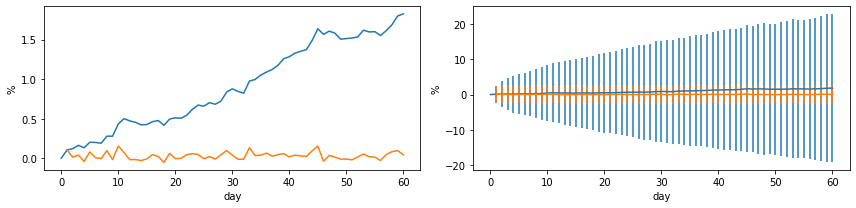

KOSPI50 종목 골든크로스 발생 횟수 :  833


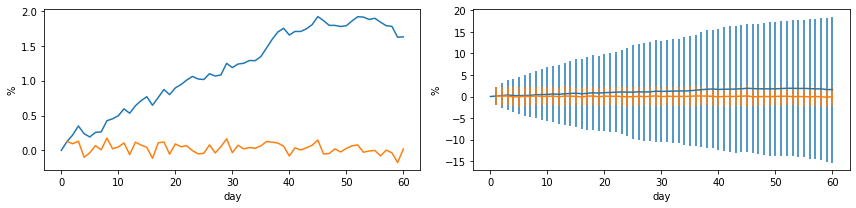

KOSDAQ150 종목 골든크로스 발생 횟수 :  2196


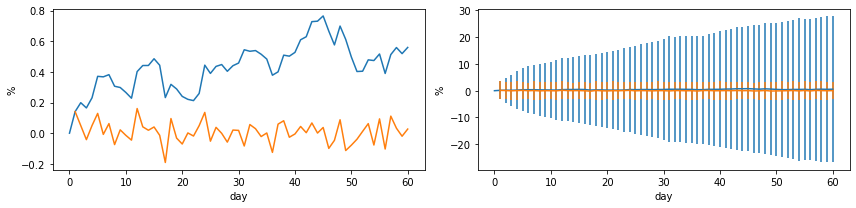

In [137]:
print('KOSPI200 종목 골든크로스 발생 횟수 : ', len(df_kospi200['gc_id'].unique()))
plt.figure(figsize=(12,3))
display_ret(df_summary_kospi200, 'close_ret_first', 'close_ret_day',  'std_ret_first', 'std_ret_day')

print('KOSPI50 종목 골든크로스 발생 횟수 : ', len(df_kospi50['gc_id'].unique()))
plt.figure(figsize=(12,3))
display_ret(df_summary_kospi50, 'close_ret_first', 'close_ret_day',  'std_ret_first', 'std_ret_day')

print('KOSDAQ150 종목 골든크로스 발생 횟수 : ', len(df_kosdaq150['gc_id'].unique()))
plt.figure(figsize=(12,3))
display_ret(df_summary_kosdaq150, 'close_ret_first', 'close_ret_day',  'std_ret_first', 'std_ret_day')

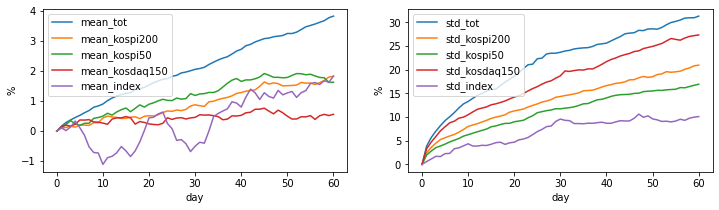

In [139]:
# 전체 종목, KOSPI200, KOSPI50, KOSDAQ150, 지수 골든크로스 수익률 통계


df_summary_tot = pd.concat([df_summary, df_summary_kospi200, df_summary_kospi50, df_summary_kosdaq150, df_summary_index], axis=1)

#df_summary_tot = df_summary_tot.loc[:, df.columns.isin(['first'])]

df_summary_tot = df_summary_tot.iloc[:,[1,5,9,13,17,3,7,11,15,19]]
#df_summary_tot = df_summary_tot.rename(columns = {0:'mean_tot', 1:'mean_kospi200', 2:'mean_kospi50', 3:'mean_kosdaq150', 4:'mean_index',
#                                                                                                        5:'std_tot', 6:'std_kospi200', 7:'std_kospi50', 8:'std_kosdaq150', 9:'std_index'})
#df_summary_tot = df_summary_tot.rename(columns = {0:'mean_tot', 1:'mean_kospi200', 2:'mean_kospi50', 3:'mean_kosdaq150', 4:'mean_index',
#                                                                                                        5:'std_tot', 6:'std_kospi200', 7:'std_kospi50', 8:'std_kosdaq150', 9:'std_index'})


str_summary_columns = ['mean_tot', 'mean_kospi200', 'mean_kospi50', 'mean_kosdaq150', 'mean_index',
                          'std_tot', 'std_kospi200', 'std_kospi50', 'std_kosdaq150', 'std_index']
df_summary_tot.columns = str_summary_columns

plt.figure(figsize=(12,3))

list_labels = str_summary_columns[:5]
plt.subplot(1, 2, 1)
for label in list_labels:
    plt.plot(df_summary_tot[label], label=label)

plt.xlabel('day')
plt.ylabel('%')

plt.legend()

list_labels = str_summary_columns[5:]
plt.subplot(1, 2, 2)
for label in list_labels:
    plt.plot(df_summary_tot[label], label=label)
    
plt.xlabel('day')
plt.ylabel('%')

plt.legend()

plt.show()



In [ ]:
# 이동평균선 움직임 패턴에 대한 k-means 군집분석을 위한 rollingmean 데이터 추출 

pd.options.display.float_format = '{:,.4f}'.format

period = 20

df1 = df.copy()

df1 = df1.groupby('gc_id').filter(lambda g: g['gc_id'].size == 61)  # days가 61까지 있는 데이터만 추출
df1 = df1.loc[df1['days'] <= period]
np.random.seed(0)
list_gcid_sample = np.random.randint(0,np.max(df['gc_id'])+1,size=5000)
df1 = df1.loc[df1['gc_id'].isin(list_gcid_sample)]

df1['first_rm_5']= df1.groupby('gc_id')['rm_5'].transform('first')
df1['rm_120'] /= df1['first_rm_5']
df1['rm_60'] /= df1['first_rm_5']
df1['rm_20'] /= df1['first_rm_5']
df1 = df1[['gc_id' , 'days', 'rm_5', 'rm_20', 'rm_60', 'rm_120']]


df1[['rm_5', 'rm_20', 'rm_60', 'rm_120']] = np.round(df1[['rm_5', 'rm_20', 'rm_60', 'rm_120']], 4)

X = df1[['rm_5', 'rm_20', 'rm_60', 'rm_120']].to_numpy().reshape(-1, period+1, 4)

df1_summary = df1.groupby('days')['rm_5', 'rm_20', 'rm_60', 'rm_120'].mean()

df1_summary.plot()


In [ ]:
# 이동평균선 움직임 패턴에 대한 k-means 군집분석

from tslearn.clustering import TimeSeriesKMeans

n_clusters = 3

km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
labels = km.fit_predict(X)

import matplotlib.pyplot as plt

sz = X.shape[1]

plt.figure(figsize=(12,3))
for yi in range(n_clusters):
    plt.subplot(1, n_clusters, yi + 1)
    #for xx in X[labels == yi]:
     #   plt.plot(xx.ravel(), "k-", alpha=.2)
    #plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    index = np.where(labels==yi)
    X_mean = X[index]
    X_mean = X_mean.mean(axis=0)
    X_mean = np.rot90(X_mean)
    plt.plot(X_mean[3], label='rm_5')
    plt.plot(X_mean[2], label='rm_20')
    plt.plot(X_mean[1], label='rm_60')
    plt.plot(X_mean[0], label='rm_120')
    plt.ylim(0.85,1.4)
    plt.legend()
    print('# of cluster {0} : {1}'.format(yi, X[index].shape[0]))


In [ ]:
df_summary['net_ret_day'] = df_summary['close_ret_day'] - df_summary['close_index_ret_day']
df_summary['net_ret_first'] = df_summary['close_ret_first'] - df_summary['close_index_ret_first']



In [99]:
# 코스피, 코스닥 지수 변동에 대한 상대 수익률

df_index_kospi = dailychart_index.loc[dailychart_index['section'] == 'KOSPI']
df_index_kosdaq = dailychart_index.loc[dailychart_index['section'] == 'KOSDAQ']
df_kospi = df.loc[df['section'] == 'KOSPI']
df_kosdaq = df.loc[df['section'] == 'KOSDAQ']

df_kospi = pd.merge(df_kospi, df_index_kospi[['date','close']], on='date')
df_kospi = df_kospi.rename(columns = {'close_x':'close', 'close_y':'close_index'})
df_kospi = df_kospi.sort_values(['gc_id','days']).reset_index(drop=True)
df_kosdaq = pd.merge(df_kosdaq, df_index_kosdaq[['date','close']], on='date')
df_kosdaq = df_kosdaq.rename(columns = {'close_x':'close', 'close_y':'close_index'})
df_kosdaq = df_kosdaq.sort_values(['gc_id','days']).reset_index(drop=True)
   
    
df_kospi = generate_return(df_kospi, 'close_index')
df_kosdaq = generate_return(df_kosdaq, 'close_index')
    
df = pd.concat([df_kospi, df_kosdaq])


# 전체 골든 크로스
df_summary = df .groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].mean()
df_summary[['std_ret_day', 'std_ret_first', 'index_std_ret_day','index_std_ret_first']] = df.groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].std()
display(HTML(df_summary.to_html()))

# 코스피 종목
df_summary_kospi = df_kospi .groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].mean()
df_summary_kospi[['std_ret_day', 'std_ret_first', 'index_std_ret_day','index_std_ret_first']] = df_kospi.groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].std()
display(HTML(df_summary_kospi.to_html()))

# 코스닥 종목
df_summary_kosdaq = df_kosdaq .groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].mean()
df_summary_kosdaq[['std_ret_day', 'std_ret_first', 'index_std_ret_day','index_std_ret_first']] = df_kosdaq.groupby('days')['close_ret_day', 'close_ret_first', 'close_index_ret_day', 'close_index_ret_first'].std()
display(HTML(df_summary_kosdaq.to_html()))



<re.Match object; span=(0, 1), match='a'>

In [ ]:
# 120일 선이 하락추세일 때  상승하지 않음
#df.loc[df['gc_id'] == 4, 'close'].plot()

# 2014년 이후 코스탁 → 코스피 이전 상장 기업

한국토지신탁(2016.7.11), 카카오(2017.7.10), 셀트리온(2018,2,9), 더블유게임즈(2019.3.12),  포스코케미칼(2019,5,29)

# 코스피200 , 코스닥150 종목 변경일

2014. 6. 13
2015. 6. 12
2016. 6. 10
2017. 6. 9
2018. 6. 15
2019. 6. 14
2020. 6. 12
2020.12.11
2021. 6. 11


# 코스닥150 종목 변경일

2015. 7. 13
2015. 12. 11
2016. 6. 10
2016. 12. 9
2017. 6. 9
2017. 12. 15
2018. 6. 15
2018. 12. 14
2019. 6. 14
2019. 12. 13
2020. 6. 12
2020.12.11
2021. 6. 11



# CpSvr7254 : 투자주체별현황을 일별/기간별, 순매수/매매비중을 일자별로 확인할수 있습니다.

In [ ]:
# 2. 골드크로스 발생일로부터 120영업일 이내 재발생된 골드크로스 제외

def filter_prev_days(df, days):
    df_date = pd.DataFrame(dailychart['date'].unique(), columns =['date'])
    df_date = df_date.reset_index()
    df_date = df_date.rename(columns={'index':'idx'})

    df_first = df.loc[df['days'] == 0]

    df_first = pd.merge(df_first, df_date, left_on='date',right_on='date')
    df_first = df_first.sort_values('gc_id')
    df_first = df_first.loc[ ~((df_first['idx'] - df_first.shift(1)['idx'] <= days) & (df_first['code'] == df_first.shift(1)['code']))]

    df_filtered = df.loc[df['gc_id'].isin(df_first['gc_id'])]
    
    return df_filtered

    
df_filter_120days = filter_prev_days(df, 120)
df_summary_filter_120days = df_filter_120days.groupby('days')['close_ret_day', 'close_ret_first'].mean()
df_summary_filter_120days[['std_ret_day', 'std_ret_first']] = df_filter_120days.groupby('days')['close_ret_day', 'close_ret_first'].std()

display(HTML(df_summary_filter_120days.to_html()))
